### Notebook to genereate mean vertical profiles from TC output

Assumes output is in a single netcdf file on pressure levels.

James Ruppert  
jruppert@ou.edu  
4/23/22

In [27]:
from netCDF4 import Dataset
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sys
from thermo_functions import density_moist, theta_dry, theta_equiv, theta_virtual, relh
from stratiform_index import stratiform_index

#### Time selection

#### Directories

In [28]:
storm = 'haiyan'
main = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/wrfenkf/"

imemb='memb_01'

datdir = main+storm+'/'+imemb+'/ctl/post/d02/v2/'
print(datdir)

/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/wrfenkf/haiyan/memb_01/ctl/post/d02/v2/


#### Read variables

In [29]:
# Two-dimensional variables

# Conv/strat separation: varout = 1 if convective, = 2 if stratiform, = 3 other, = 0 if no rain
# varfil_strat = Dataset(datdir+'strat_orig.nc') # this opens the netcdf file
# strat1 = varfil_strat.variables['strat'][0,:,:,:]
varfil_strat = Dataset(datdir+'../strat.nc') # this opens the netcdf file
strat1 = varfil_strat.variables['strat'][36,:,:,:]
varfil_strat.close()

varfil_strat = Dataset(datdir+'strat.nc') # this opens the netcdf file
strat2 = varfil_strat.variables['strat'][0,:,:,:]
varfil_strat.close()

it0=36
varfil_strat = Dataset(datdir+'W.nc') # this opens the netcdf file
pres = varfil_strat.variables['pres'][:] # hPa
w = varfil_strat.variables['W'][it0,:,:,:]
varfil_strat.close()

bv_shape = np.shape(w)
nt = bv_shape[0]
nx1 = bv_shape[1]
nx1 = bv_shape[2]

In [30]:
# # Three-dimensional variables

# # Vertical coordinate
# filtmp = Dataset(datdir+'W.nc')
# pres = filtmp.variables['pres'][:] # hPa
# print("Vertical shape: ",np.shape(pres))
# filtmp.close()

# bv_shape = np.shape(w)
# print("Binvar shape: ",bv_shape)
# nt = bv_shape[0]
# nx1 = bv_shape[1]
# nx1 = bv_shape[2]
# # nx2 = bv_shape[3]

#### Average for Conv, Strat, and Anvil

In [31]:
indices_c1 = np.where(strat1[0,:,:] == 1)
indices_s1 = np.where(strat1[0,:,:] == 2)
indices_a1 = np.where(strat1[0,:,:] >= 2)
indices_c2 = np.where(strat2[0,:,:] == 1)
indices_s2 = np.where(strat2[0,:,:] == 2)
indices_a2 = np.where(strat2[0,:,:] >= 2)

count_c1 = indices_c1[0].size
count_s1 = indices_s1[0].size
count_a1 = indices_a1[0].size
count_c2 = indices_c2[0].size
count_s2 = indices_s2[0].size
count_a2 = indices_a2[0].size

w_c1 = np.mean(w[:,indices_c1[0],indices_c1[1]], axis=1)
w_s1 = np.mean(w[:,indices_s1[0],indices_s1[1]], axis=1)
w_a1 = np.mean(w[:,indices_a1[0],indices_a1[1]], axis=1)
w_c2 = np.mean(w[:,indices_c2[0],indices_c2[1]], axis=1)
w_s2 = np.mean(w[:,indices_s2[0],indices_s2[1]], axis=1)
w_a2 = np.mean(w[:,indices_a2[0],indices_a2[1]], axis=1)

---
### Plotting routines

In [32]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

### Plot profiles

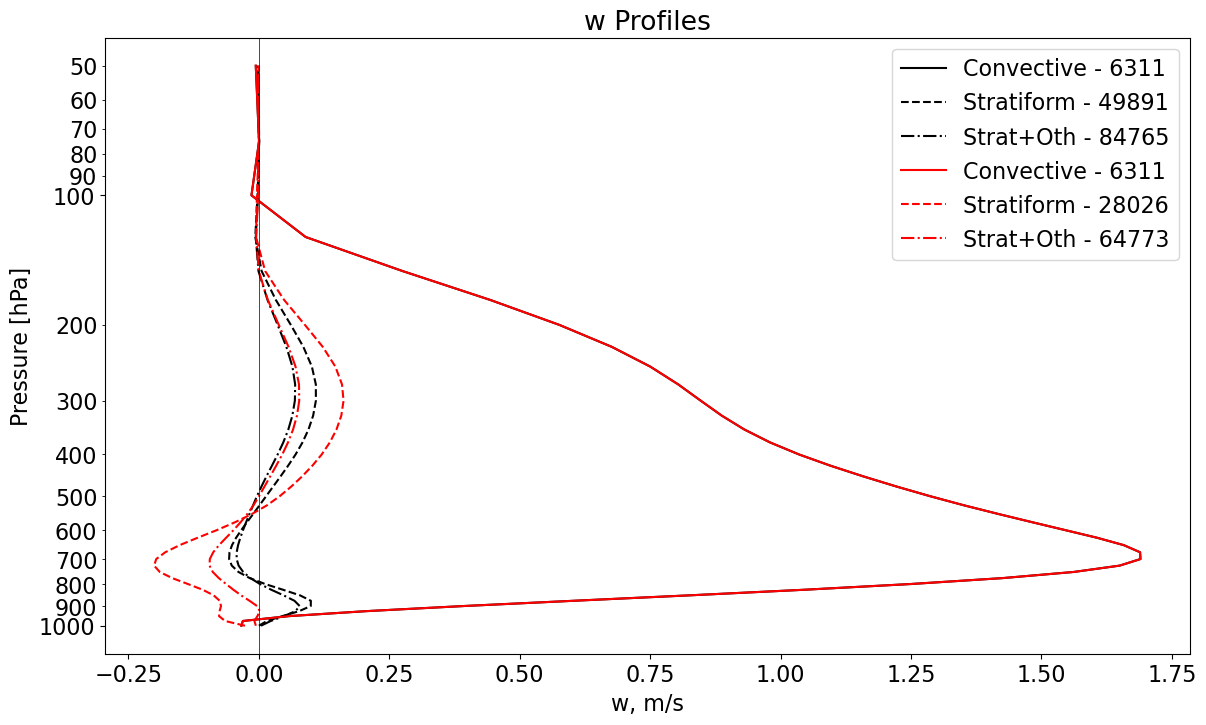

In [33]:
# create figure
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(111)

ax.set_title('w Profiles')
ax.set_ylabel('Pressure [hPa]')

ax.invert_yaxis()
ax.set_yscale('log')

plt.plot(w_c1, pres, "-k", label="Convective - "+str(count_c1))
plt.plot(w_s1, pres, "--k", label="Stratiform - "+str(count_s1))
plt.plot(w_a1, pres, "-.k", label="Strat+Oth - "+str(count_a1))
plt.plot(w_c2, pres, "-r", label="Convective - "+str(count_c2))
plt.plot(w_s2, pres, "--r", label="Stratiform - "+str(count_s2))
plt.plot(w_a2, pres, "-.r", label="Strat+Oth - "+str(count_a2))

ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.yaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())

plt.axvline(x=0,color='k',linewidth=0.5)
ax.set_xlabel('w, m/s')
# plt.xlim(np.min(bins), np.max(bins))
plt.legend(loc="upper right")

plt.show()
# plt.savefig(figdir+figtag+'_compcross_'+imemb+'_'+ivar_select+'.png',dpi=200, facecolor='white', \
#             bbox_inches='tight', pad_inches=0.2)